In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc1


In [3]:
def weighted_avg_and_std(values, weights):
    import math
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def plot_sigma_slope(run):
    
    file_name = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/outfiles/cosmos_bplanck_run_{0}.hdf5'.format(str(run))
    reader = emcee.backends.HDFBackend(file_name)
    
#     tau = reader.get_autocorr_time()
#     burnin = int(2*np.max(tau))
#     thin = int(0.5*np.min(tau))


    burnin = 4000
    thin = 1


    chains = reader.get_chain()
    log_prob = reader.get_log_prob()
    
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print('{0} walkers'.format(chains.shape[1]))
    print('{0} iterations per walker so far ({1} total)'.format(chains.shape[0],
                                                                chains.shape[0]*chains.shape[1]))
    
    chains = reader.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
    print('{0} iterations being used total'.format(chains.shape[0]))

    #only first 2 params
    sigma_2, sigma_3 =  chains.T[:2]

    #flatten walker chains together
    sigma_2_flat, sigma_3_flat = sigma_2.T.flatten(), sigma_3.T.flatten()

    #get means and sigmas
    mean_sigma2, std_sigma2 = weighted_avg_and_std(sigma_2_flat, np.exp(log_prob))
    mean_sigma3, std_sigma3 = weighted_avg_and_std(sigma_3_flat, np.exp(log_prob))

    #plot
    fig, axes=plt.subplots(1,2, figsize=[15,6])
    
    #left subplot: Vmax@Mpeak
    axes[0].errorbar([2,3], [mean_sigma2, mean_sigma3],yerr=[std_sigma2, std_sigma3],
            c=plt.get_cmap('tab20')(0), linewidth=3, linestyle='--', marker='o', label = 'model')
    axes[0].fill_between([2,3], [mean_sigma2+std_sigma2, mean_sigma3+std_sigma3],
                     [mean_sigma2-std_sigma2,  mean_sigma3-std_sigma3],
                     color=plt.get_cmap('tab20')(0), alpha=0.3)

    axes[0].set_xlabel(r'$\log(V_{max}@M_{peak}$)', fontsize=25)
    axes[0].set_ylabel(r'$\sigma_{M_* | V_{max}@M_{peak}}$', fontsize=25)
    axes[0].legend()
    
    #right subplot: mvir
    axes[1].scatter(bin_centers, binned_scatter, marker='+', color=plt.get_cmap('tab20')(0),
                 label = 'model', linewidth=3)
#     axes[1].errorbar([10,13], [mean_sigma2, mean_sigma3],yerr=[std_sigma2, std_sigma3],
#             c=plt.get_cmap('tab20')(0), linewidth=3, linestyle='--', marker='o', label = 'model')
#     axes[1].fill_between([10,13], [mean_sigma2+std_sigma2, mean_sigma3+std_sigma3],
#                      [mean_sigma2-std_sigma2,  mean_sigma3-std_sigma3],
#                      color=plt.get_cmap('tab20')(0), alpha=0.3)
    
    GK = lambda Mhalo, M1: 0.2 - (0.26*(Mhalo-M1))
    Munshi = lambda Mhalo: GK(Mhalo,9.7) if Mhalo<9.7 else 0.1
    Wasserman = lambda Mhalo: GK(Mhalo,11.5) if Mhalo<11.5 else 0.2
    x = np.array([10,11.5, 13])
    axes[1].plot(x, [Munshi(xi)for xi in x], c=plt.get_cmap('tab20')(2), linewidth=3, linestyle='--', marker='o',
                 label = 'Munshi+2017')
    axes[1].plot(x, [Wasserman(xi) for xi in x], c=plt.get_cmap('tab20')(4), linewidth=3, linestyle='--', marker='o',
                 label = 'Wasserman+2018')
    

    axes[1].set_xlabel(r'$\log(M_{vir}$)', fontsize=25)
    axes[1].set_ylabel(r'$\sigma_{M_* | M_{vir}}$', fontsize=25)
    axes[1].legend()

    plt.show()

In [4]:
run='Vmax_4'

config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)

5SHMR+scatter (Vmax@Mpeak)


In [5]:
best_params = [ 0.53903687,  0.11330591,  2.72161542, 11.01133551,  0.11815845,  0.70730249,  0.28967114]

In [6]:
stellar_masses = get_chris_stellar_masses(best_params, config, sim_data)
halo_data = sim_data['halocat'].halo_table
halo_data['M_*'] = 10**stellar_masses

## plot sigma function

In [7]:
n_bins=20
bins=np.linspace(10,13,n_bins)
dx = bins[1]-bins[0]
bin_centers = bins[:-1]+dx/2.

halo_data_10_13 = halo_data[(halo_data['halo_mvir']>1e9) & (halo_data['halo_mvir']<1e14)]
binned_scatter, _, _ = binned_statistic(np.log10(halo_data_10_13['halo_mvir']),np.log10(halo_data_10_13['M_*']), 
                                  bins=bins, statistic=lambda x: np.std(x))

/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [136]:
binned_scatter

array([0.90936983, 0.87827043, 0.83855767, 0.80110256, 0.76807016,
       0.72539045, 0.67897231, 0.63056283, 0.58090089, 0.53918965,
       0.50341457, 0.46570288, 0.44433129, 0.41468271, 0.39469153,
       0.37250117, 0.34866831, 0.32334291, 0.30624798])

burn-in: 4000
thin: 1
15 walkers
10000 iterations per walker so far (150000 total)
90000 iterations being used total


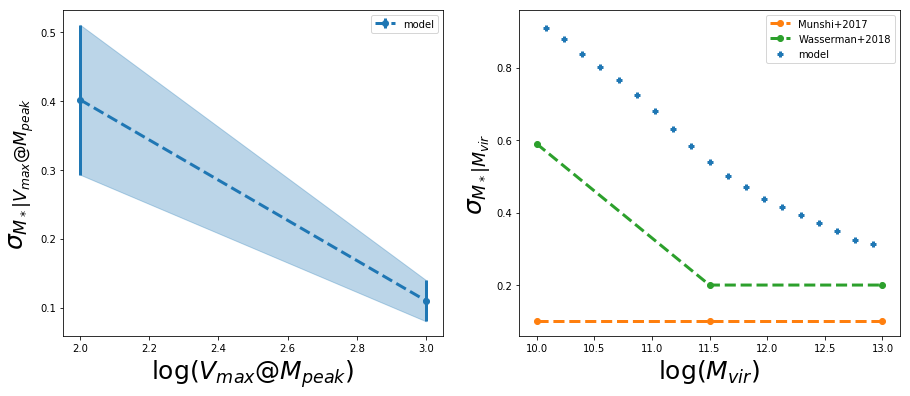

In [25]:
run='Vmax_4'
plot_sigma_slope(run)

## make catalog of all galaxies for alexie

In [8]:
halo_data_reduced = halo_data['M_*','halo_mpeak','halo_mvir','halo_Vmax@Mpeak', 'halo_pid']
halo_data_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_full_catalog.ascii',
                  format ='ascii', overwrite=True, comment='#'  )



## making catalog of low mass galaxies with best fit params

stellar masses around 2x10^8 Msun

send Alexie a catalog of these objects with : M*, Mhalo, Mpeak, vMax@mpeak

In [56]:
dwarf_mass = np.log10(2e8)
dwarf_halos = halo_data[(np.log10(halo_data['M_*'])>dwarf_mass-0.01) & (np.log10(halo_data['M_*'])<dwarf_mass+0.01)]

In [57]:
dwarf_halos

halo_upid,halo_y,halo_x,halo_z,halo_Vmax@Mpeak,halo_rvir,halo_vy,halo_id,halo_vx,halo_mpeak,halo_vz,halo_mvir,halo_hostid,halo_mvir_host_halo,M_*
int64,float32,float32,float32,float64,float32,float32,int64,float32,float32,float32,float32,int64,float32,float64
2404371171,42.46758,36.31219,18.73313,92.82,0.041286997,-400.74,2404371659,-20.93,48970000000.0,191.32,6509000000.0,2404371171,162700000000000.0,8.295252853172773
2402455808,13.49677,21.82855,10.31479,78.57,0.038479,-18.81,2402456076,-663.6,23560000000.0,436.6,5269000000.0,2402455808,119200000000000.0,8.294212778657263
2402481157,25.03206,15.76387,24.31598,79.38,0.040279,-110.16,2402481322,-925.65,35950000000.0,262.85,6044000000.0,2402481157,70480000000000.0,8.302581457767442
2402481668,27.64672,4.03123,22.59529,55.95,0.036905997,222.71,2402481740,-199.82,12240000000.0,-58.91,4649000000.0,2402481668,32670000000000.0,8.3017348973843
2402471181,18.30066,13.31102,14.08953,67.53,0.032241,127.7,2402471202,240.34,14260000000.0,52.68,3099000000.0,2402471181,18270000000000.0,8.304020621077418
2404384064,44.71968,42.50826,39.70943,85.19,0.035867,570.7,2404384080,623.94,44320000000.0,-148.11,4261000000.0,2404384064,17710000000000.0,8.29769067012952
2402670473,34.99328,26.66337,4.76281,80.44,0.035187,-243.27,2402670496,298.8,27430000000.0,519.89,4029000000.0,2402670473,10860000000000.0,8.309039854993358
2402671391,41.33159,16.63626,7.10704,91.08,0.028627,-159.88,2402671392,-206.59,49740000000.0,26.57,2169000000.0,2402671391,5755000000000.0,8.308160428092185
2402458695,17.76208,31.16812,9.05085,67.65,0.047757,20.07,2402458701,-317.17,35020000000.0,-241.6,10070000000.0,2402458695,4523000000000.0,8.296480496114857


In [39]:
dwarf_halos.keys()

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_Vmax@Mpeak',
 'halo_rvir',
 'halo_vy',
 'halo_id',
 'halo_vx',
 'halo_mpeak',
 'halo_vz',
 'halo_mvir',
 'halo_hostid',
 'halo_mvir_host_halo',
 'M_*']

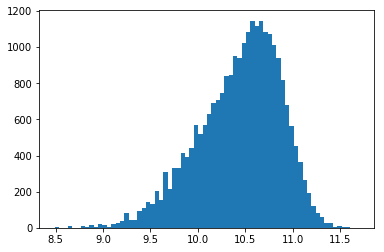

In [23]:
plt.hist(np.log10(dwarf_halos['halo_mvir']), bins=70)
plt.xlim
plt.show()

In [35]:
dwarf_halos.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog.hdf5',
                  path ='catalog', overwrite=True )



In [59]:
dwarf_halos_reduced = dwarf_halos['halo_mvir','halo_mpeak','halo_Vmax@Mpeak','M_*']
dwarf_halos_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog_short.ascii',
                  format ='ascii', overwrite=True, comment='#' )

